In [1]:
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, AIMessage , SystemMessage
from dotenv import load_dotenv


from langchain_core.tools import tool
from langchain_core.messages import BaseMessage
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict,Type,List, Union
from typing import Annotated, Sequence


class AgentState(TypedDict):
    """ Agente that managed state of the agent"""
    messages: Annotated[Sequence[BaseMessage], add_messages]
    count: int
    
llm = ChatOpenAI(model="gpt-4o")


@tool(description="Tool add numbers int")
def add(x:int , y:int)-> int:
    """" Function that sum two numbers"""
    return x+y

@tool(description="Tool multiply two numbers int")
def multiply(x:int , y:int) -> int:
    """Function that multiply two numbers"""
    return x*y

tools = [add, multiply]
llm_with_tools = llm.bind_tools(tools)


sys_msg = SystemMessage(content = """Eres un asistente que realizara operaciones aritmeticas los cuales 
          los cuales puedes utilizar de {tools}.
          A su vez indicaras cual sera la mejor operacion 
          a realizar.     
         """)
         
def assistant(state: AgentState)-> AgentState:
    """Eres un node de asisstant que permite mostrar los mensajes y 
       ejecutarlos
    """
    response = llm_with_tools.invoke([sys_msg] + state["messages"])
    return {"messages": response}

toolNode = ToolNode(tools)



OpenAIError: The api_key client option must be set either by passing api_key to the client or by setting the OPENAI_API_KEY environment variable

In [17]:
#agent with memory in ram
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

graph = StateGraph(AgentState)
graph.add_node("assistant", assistant)
graph.add_node("tools", toolNode)
graph.add_edge(START, "assistant")
graph.add_conditional_edges(
    "assistant",
    tools_condition
)
graph.add_edge("tools","assistant")
graph.add_edge("assistant",END)
#agent with memory
agent_whit_memory = graph.compile(checkpointer=memory)



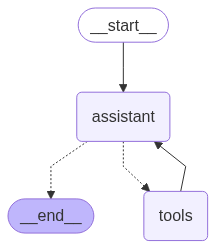

In [18]:
from IPython.display import Image, display
agent = graph.compile()
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [19]:


# Specify a thread
config = {"configurable": {"thread_id": "1"}}

messages = HumanMessage(content="puedes sumar 2 + 2")
messages = agent_whit_memory.invoke({"messages": messages},config)
for m in messages["messages"]:
    m.pretty_print()
    
messages = HumanMessage(content="al resultado sumale 3 ")
messages = agent_whit_memory.invoke({"messages": messages},config)
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

puedes sumar 2 + 2
================================== Ai Message ==================================

Sumar dos números es una operación básica. Para el caso de \(2 + 2\), usaré la operación de suma. Permíteme calcularlo para ti.
Tool Calls:
  add (call_uMzo2sleh91i2Ddeh7US99Ua)
 Call ID: call_uMzo2sleh91i2Ddeh7US99Ua
  Args:
    x: 2
    y: 2
================================= Tool Message =================================
Name: add

4
================================== Ai Message ==================================

La suma de \(2 + 2\) es \(4\).
================================ Human Message =================================

puedes sumar 2 + 2
================================== Ai Message ==================================

Sumar dos números es una operación básica. Para el caso de \(2 + 2\), usaré la operación de suma. Permíteme calcularlo para ti.
Tool Calls:
  add (call_uMzo2sleh91i2Ddeh7US99Ua)
 Call

In [ ]:
# =============================================================================
# EJEMPLO PRÁCTICO: MEMORYSAVER - Memoria entre conversaciones
# =============================================================================

from langgraph.checkpoint.memory import MemorySaver
import uuid

# 1. Crear el MemorySaver
memory = MemorySaver()

# 2. Compilar el agente CON memoria
agent_with_memory = graph.compile(checkpointer=memory)

# 3. Crear un thread_id único para esta sesión de conversación
thread_id = str(uuid.uuid4())
config = {"configurable": {"thread_id": thread_id}}

print(f"🧠 Sesión de memoria iniciada con Thread ID: {thread_id[:8]}...")
print("="*60)

================================ Human Message =================================

al resultado sumale 3 
================================== Ai Message ==================================

Para ayudarte adecuadamente, necesito saber qué números deseas sumar primero. ¿Puedes proporcionarme esos números?


In [ ]:
# =============================================================================
# CONVERSACIÓN 1: Establecer contexto inicial
# =============================================================================

print("🗣️  CONVERSACIÓN 1: Estableciendo información personal")
print("-" * 50)

# Primera interacción - el agente aprende sobre el usuario
response1 = agent_with_memory.invoke(
    {"messages": [HumanMessage("Hola! Mi nombre es María y soy estudiante de matemáticas. Me gusta resolver problemas complejos.")]}, 
    config=config
)

print("👤 Usuario: Hola! Mi nombre es María y soy estudiante de matemáticas...")
print("🤖 Asistente:")
for m in response1["messages"]:
    if hasattr(m, 'content') and m.content:
        print(f"   {m.content}")

print("\n" + "="*60)

In [ ]:
# =============================================================================
# CONVERSACIÓN 2: El agente recuerda información previa
# =============================================================================

print("🗣️  CONVERSACIÓN 2: Testing memoria - ¿Recuerda mi nombre?")
print("-" * 50)

# Segunda interacción - verificar que recuerda
response2 = agent_with_memory.invoke(
    {"messages": [HumanMessage("¿Cuál es mi nombre y qué estudio?")]}, 
    config=config  # Mismo thread_id = misma memoria
)

print("👤 Usuario: ¿Cuál es mi nombre y qué estudio?")
print("🤖 Asistente:")
for m in response2["messages"]:
    if hasattr(m, 'content') and m.content and m != response1["messages"][-1]:
        print(f"   {m.content}")

print("\n" + "="*60)

In [ ]:
# =============================================================================
# CONVERSACIÓN 3: Operaciones matemáticas con contexto
# =============================================================================

print("🗣️  CONVERSACIÓN 3: Realizando cálculos con memoria contextual")
print("-" * 50)

# Tercera interacción - operación matemática
response3 = agent_with_memory.invoke(
    {"messages": [HumanMessage("Vamos a resolver: 15 + 28, y luego multiplica el resultado por 3")]}, 
    config=config
)

print("👤 Usuario: Vamos a resolver: 15 + 28, y luego multiplica el resultado por 3")
print("🤖 Asistente (con memoria y herramientas):")
for m in response3["messages"]:
    if hasattr(m, 'content') and m.content:
        print(f"   {m.content}")

print("\n" + "="*60)

In [ ]:
# =============================================================================
# CONVERSACIÓN 4: Referencia a resultados anteriores
# =============================================================================

print("🗣️  CONVERSACIÓN 4: ¿Recuerda cálculos anteriores?")
print("-" * 50)

# Cuarta interacción - referencia a cálculos previos
response4 = agent_with_memory.invoke(
    {"messages": [HumanMessage("¿Cuál fue el resultado final del cálculo anterior? ¿Y cómo llegamos a ese número?")]}, 
    config=config
)

print("👤 Usuario: ¿Cuál fue el resultado final del cálculo anterior? ¿Y cómo llegamos a ese número?")
print("🤖 Asistente:")
for m in response4["messages"]:
    if hasattr(m, 'content') and m.content:
        print(f"   {m.content}")

print("\n" + "="*60)

In [ ]:
# =============================================================================
# DEMOSTRACIÓN: NUEVA SESIÓN (Nuevo Thread ID)
# =============================================================================

print("🔄 NUEVA SESIÓN: Cambiando Thread ID")
print("-" * 50)

# Crear un nuevo thread_id (nueva sesión)
new_thread_id = str(uuid.uuid4())
new_config = {"configurable": {"thread_id": new_thread_id}}

print(f"🆕 Nuevo Thread ID: {new_thread_id[:8]}...")

# Preguntar lo mismo en la nueva sesión
response_new = agent_with_memory.invoke(
    {"messages": [HumanMessage("¿Cuál es mi nombre?")]}, 
    config=new_config  # DIFERENTE thread_id = NO hay memoria
)

print("👤 Usuario: ¿Cuál es mi nombre?")
print("🤖 Asistente (nueva sesión - sin memoria):")
for m in response_new["messages"]:
    if hasattr(m, 'content') and m.content:
        print(f"   {m.content}")

print("\n" + "="*60)
print("💡 NOTA: El agente NO recuerda porque es una sesión diferente!")

# 🧠 **MEMORYSAVER - Análisis Técnico**

## 🔍 **¿Qué acabamos de ver?**

### ✅ **Con MemorySaver (mismo thread_id):**
- El agente **RECUERDA** el nombre "María" 
- **RECUERDA** que estudia matemáticas
- **RECUERDA** los cálculos realizados (15+28=43, 43*3=129)
- **MANTIENE** contexto entre múltiples conversaciones

### ❌ **Nueva sesión (diferente thread_id):**
- El agente **NO RECUERDA** nada de la conversación anterior
- Cada `thread_id` es una **sesión independiente**

## ⚙️ **Características del MemorySaver:**

| Característica | Detalle |
|---------------|---------|
| **Persistencia** | ❌ Solo en memoria RAM |
| **Reinicio app** | ❌ Se pierde todo |
| **Thread_id** | ✅ Sesiones independientes |
| **Velocidad** | ✅ Muy rápido |
| **Uso** | 🎯 Desarrollo y testing |

## 💡 **Mejores Prácticas:**

1. **Thread ID único por usuario/sesión**
2. **Use para desarrollo y pruebas**
3. **Para producción → SqliteSaver o PostgresSaver**
4. **Limpie memoria periódicamente si es necesario**

## 🚀 **Siguiente paso:** 
- Probar **SqliteSaver** para persistencia real
- Combinar con **Memory Stores** para datos específicos